# Foundations-2025 — Simple Neural Network (1 hidden layer) from scratch

**Purpose:** Build and train a vanilla feedforward neural network with one hidden layer using **NumPy only**. This Kaggle-ready notebook explains architecture, forward pass, backpropagation, initialization, training loop, diagnostics, and extensions (regularization, learning rate schedules, and weight saving).

**Usage:** Run cells sequentially in a Kaggle kernel. The notebook uses NumPy, scikit-learn, and matplotlib which are available on Kaggle by default.


In [1]:
# Environment check (optional)
import sys, platform, numpy as np, sklearn, matplotlib
print('Python:', sys.version.splitlines()[0])
print('Platform:', platform.platform())
print('NumPy:', np.__version__, 'scikit-learn:', sklearn.__version__, 'matplotlib:', matplotlib.__version__)


Python: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
Platform: Linux-6.6.105+-x86_64-with-glibc2.35
NumPy: 1.26.4 scikit-learn: 1.2.2 matplotlib: 3.7.2


## Imports & helper utilities
Minimal utilities for reproducibility, batching, metrics, and plotting.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons, make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss
np.random.seed(0)

def add_bias(X):
    return np.hstack([np.ones((X.shape[0],1)), X])

def one_hot(y, num_classes):
    Y = np.zeros((y.size, num_classes))
    Y[np.arange(y.size), y] = 1
    return Y

def shuffle_batch(X, y):
    idx = np.random.permutation(X.shape[0])
    return X[idx], y[idx]


## Math & Architecture
We implement a 1-hidden-layer network:

- Input dimension: `D`
- Hidden units: `H` with ReLU activation
- Output: single logit with sigmoid (binary) or `C` logits + softmax (multiclass)

Loss: binary cross-entropy for binary classification. We'll implement forward, backward, parameter updates (SGD / mini-batch) and evaluate accuracy and log-loss.


## 1) Implementation (binary classification with sigmoid output)

In [3]:
class SimpleNN:
    def __init__(self, D, H=32, seed=0, weight_scale=0.01, reg=0.0):
        np.random.seed(seed)
        self.D = D
        self.H = H
        # small random initialization
        self.W1 = np.random.randn(D, H) * weight_scale
        self.b1 = np.zeros(H)
        self.W2 = np.random.randn(H, 1) * weight_scale
        self.b2 = np.zeros(1)
        self.reg = reg  # L2 regularization strength

    def relu(self, x):
        return np.maximum(0, x)

    def relu_grad(self, x):
        return (x > 0).astype(float)

    def sigmoid(self, x):
        x = np.clip(x, -500, 500)
        return 1 / (1 + np.exp(-x))

    def forward(self, X):
        # X: (N, D)
        z1 = X @ self.W1 + self.b1  # (N, H)
        a1 = self.relu(z1)
        z2 = a1 @ self.W2 + self.b2  # (N, 1)
        out = self.sigmoid(z2).ravel()  # (N,)
        cache = {'X': X, 'z1': z1, 'a1': a1, 'z2': z2, 'out': out}
        return out, cache

    def compute_loss(self, y_true, probs):
        # binary cross-entropy
        m = y_true.size
        eps = 1e-12
        loss = -np.mean(y_true * np.log(probs + eps) + (1 - y_true) * np.log(1 - probs + eps))
        # add L2 regularization
        loss += 0.5 * self.reg * (np.sum(self.W1**2) + np.sum(self.W2**2))
        return loss

    def backward(self, cache, y_true):
        N = y_true.size
        X = cache['X']; z1 = cache['z1']; a1 = cache['a1']; out = cache['out']
        dz2 = (out - y_true).reshape(-1,1) / N  # (N,1)
        dW2 = a1.T @ dz2 + self.reg * self.W2  # (H,1)
        db2 = dz2.sum(axis=0)  # (1,)
        da1 = dz2 @ self.W2.T  # (N,H)
        dz1 = da1 * self.relu_grad(z1)  # (N,H)
        dW1 = X.T @ dz1 + self.reg * self.W1  # (D,H)
        db1 = dz1.sum(axis=0)  # (H,)
        grads = {'dW1': dW1, 'db1': db1, 'dW2': dW2, 'db2': db2}
        return grads

    def update_params(self, grads, lr=1e-2):
        self.W1 -= lr * grads['dW1']
        self.b1 -= lr * grads['db1']
        self.W2 -= lr * grads['dW2']
        self.b2 -= lr * grads['db2']



## 2) Train function (mini-batch SGD) with diagnostics

In [4]:
def train(model, X_train, y_train, X_val=None, y_val=None, epochs=100, batch_size=32, lr=1e-2, verbose=True, lr_schedule=None):
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    N = X_train.shape[0]
    for ep in range(epochs):
        X_shuf, y_shuf = shuffle_batch(X_train, y_train)
        for i in range(0, N, batch_size):
            xb = X_shuf[i:i+batch_size]
            yb = y_shuf[i:i+batch_size]
            probs, cache = model.forward(xb)
            grads = model.backward(cache, yb)
            model.update_params(grads, lr=lr)
        probs_tr, _ = model.forward(X_train)
        loss_tr = model.compute_loss(y_train, probs_tr)
        acc_tr = accuracy_score(y_train, (probs_tr >= 0.5).astype(int))
        history['train_loss'].append(loss_tr); history['train_acc'].append(acc_tr)
        if X_val is not None:
            probs_va, _ = model.forward(X_val)
            loss_va = model.compute_loss(y_val, probs_va)
            acc_va = accuracy_score(y_val, (probs_va >= 0.5).astype(int))
            history['val_loss'].append(loss_va); history['val_acc'].append(acc_va)
        if lr_schedule is not None:
            lr = lr_schedule(ep, lr)
        if verbose and (ep % max(1, epochs//10) == 0 or ep==epochs-1):
            if X_val is not None:
                print(f'Epoch {ep+1}/{epochs} - train_loss={loss_tr:.4f}, val_loss={loss_va:.4f}, train_acc={acc_tr:.3f}, val_acc={acc_va:.3f}')
            else:
                print(f'Epoch {ep+1}/{epochs} - train_loss={loss_tr:.4f}, train_acc={acc_tr:.3f}')
    return history


## 3) Experiments — Binary classification on `make_moons` (non-linear)

Epoch 1/200 - train_loss=0.6300, val_loss=0.6291, train_acc=0.848, val_acc=0.850
Epoch 21/200 - train_loss=0.3060, val_loss=0.2805, train_acc=0.870, val_acc=0.850
Epoch 41/200 - train_loss=0.3007, val_loss=0.2755, train_acc=0.873, val_acc=0.850
Epoch 61/200 - train_loss=0.2940, val_loss=0.2700, train_acc=0.875, val_acc=0.870
Epoch 81/200 - train_loss=0.2835, val_loss=0.2616, train_acc=0.885, val_acc=0.870
Epoch 101/200 - train_loss=0.2645, val_loss=0.2407, train_acc=0.897, val_acc=0.880
Epoch 121/200 - train_loss=0.2412, val_loss=0.2190, train_acc=0.905, val_acc=0.920
Epoch 141/200 - train_loss=0.2132, val_loss=0.1856, train_acc=0.922, val_acc=0.950
Epoch 161/200 - train_loss=0.1851, val_loss=0.1487, train_acc=0.930, val_acc=0.960
Epoch 181/200 - train_loss=0.1621, val_loss=0.1213, train_acc=0.940, val_acc=0.960
Epoch 200/200 - train_loss=0.1454, val_loss=0.1011, train_acc=0.948, val_acc=0.970

Final Test accuracy: 0.97
Final Test log-loss: 0.0988865252072573


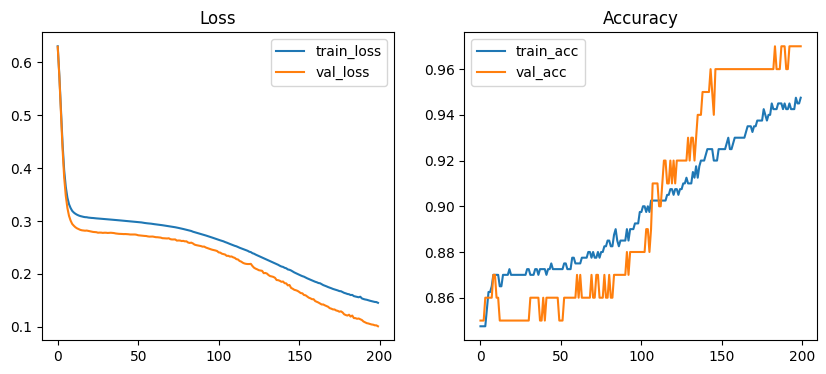

In [5]:
# Dataset
X, y = make_moons(n_samples=500, noise=0.2, random_state=0)
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=1)

# Standardize features
mean = Xtr.mean(axis=0); std = Xtr.std(axis=0) + 1e-9
Xtr = (Xtr - mean) / std
Xte = (Xte - mean) / std

# Model
D = Xtr.shape[1]
model = SimpleNN(D=D, H=32, seed=1, weight_scale=0.1, reg=1e-4)

# Train
history = train(model, Xtr, ytr, X_val=Xte, y_val=yte, epochs=200, batch_size=32, lr=0.1, verbose=True)

# Final eval
probs_test, _ = model.forward(Xte)
preds_test = (probs_test >= 0.5).astype(int)
print('\nFinal Test accuracy:', accuracy_score(yte, preds_test))
print('Final Test log-loss:', log_loss(yte, probs_test))

# Plot training curves
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history['train_loss'], label='train_loss')
plt.plot(history['val_loss'], label='val_loss')
plt.legend(); plt.title('Loss')
plt.subplot(1,2,2)
plt.plot(history['train_acc'], label='train_acc')
plt.plot(history['val_acc'], label='val_acc')
plt.legend(); plt.title('Accuracy')
plt.show()


## 4) Decision boundary visualization (2D)

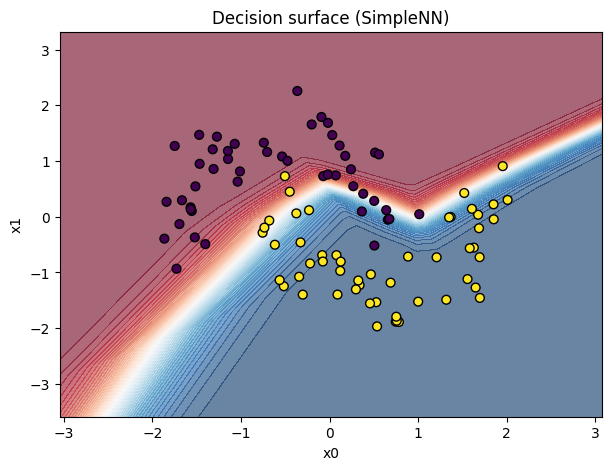

In [6]:
# Decision boundary (grid)
xx, yy = np.meshgrid(np.linspace(Xtr[:,0].min()-1, Xtr[:,0].max()+1, 300),
                     np.linspace(Xtr[:,1].min()-1, Xtr[:,1].max()+1, 300))
grid = np.c_[xx.ravel(), yy.ravel()]
# apply same standardization
grid = (grid - mean) / std
probs_grid, _ = model.forward(grid)
probs_grid = probs_grid.reshape(xx.shape)

plt.figure(figsize=(7,5))
plt.contourf(xx, yy, probs_grid, levels=50, cmap='RdBu', alpha=0.6)
plt.scatter(Xte[:,0], Xte[:,1], c=yte, edgecolor='k', s=40)
plt.title('Decision surface (SimpleNN)'); plt.xlabel('x0'); plt.ylabel('x1'); plt.show()


## 5) Extension — Multiclass (softmax) & gradient check
We include a compact multiclass forward/backward and a small numeric gradient check for correctness (optional).

In [7]:
# Multiclass variant (compact) - one hidden layer, softmax output
class SimpleNNMulti(SimpleNN):
    def __init__(self, D, H=64, C=3, seed=0, weight_scale=0.01, reg=0.0):
        super().__init__(D, H, seed, weight_scale, reg)
        self.C = C
        # override final weights
        self.W2 = np.random.randn(H, C) * weight_scale
        self.b2 = np.zeros(C)

    def softmax(self, x):
        x = x - x.max(axis=1, keepdims=True)
        e = np.exp(x)
        return e / e.sum(axis=1, keepdims=True)

    def forward_multi(self, X):
        z1 = X @ self.W1 + self.b1
        a1 = self.relu(z1)
        z2 = a1 @ self.W2 + self.b2
        probs = self.softmax(z2)
        cache = {'X': X, 'z1': z1, 'a1': a1, 'z2': z2, 'probs': probs}
        return probs, cache

    def compute_loss_multi(self, Y_true, probs):
        # Y_true: one-hot (N,C)
        N = Y_true.shape[0]
        eps=1e-12
        loss = -np.sum(Y_true * np.log(probs + eps)) / N
        loss += 0.5 * self.reg * (np.sum(self.W1**2) + np.sum(self.W2**2))
        return loss

    def backward_multi(self, cache, Y_true):
        N = Y_true.shape[0]
        X = cache['X']; z1 = cache['z1']; a1 = cache['a1']; probs = cache['probs']
        dz2 = (probs - Y_true) / N  # (N,C)
        dW2 = a1.T @ dz2 + self.reg * self.W2  # (H,C)
        db2 = dz2.sum(axis=0)
        da1 = dz2 @ self.W2.T  # (N,H)
        dz1 = da1 * self.relu_grad(z1)
        dW1 = X.T @ dz1 + self.reg * self.W1
        db1 = dz1.sum(axis=0)
        grads = {'dW1': dW1, 'db1': db1, 'dW2': dW2, 'db2': db2}
        return grads

# Numeric gradient check (small network & tiny data)
def numeric_grad_check():
    np.random.seed(1)
    Xs = np.random.randn(5,2)
    ys = np.array([0,1,2,1,0])
    Ym = one_hot(ys, 3)
    model = SimpleNNMulti(D=2, H=5, C=3, seed=2, weight_scale=0.1, reg=1e-3)
    probs, cache = model.forward_multi(Xs)
    loss = model.compute_loss_multi(Ym, probs)
    grads = model.backward_multi(cache, Ym)
    # numeric approx for W1[0,0]
    eps = 1e-5
    orig = model.W1[0,0]
    model.W1[0,0] = orig + eps
    probs_p, _ = model.forward_multi(Xs)
    loss_p = model.compute_loss_multi(Ym, probs_p)
    model.W1[0,0] = orig - eps
    probs_m, _ = model.forward_multi(Xs)
    loss_m = model.compute_loss_multi(Ym, probs_m)
    num_grad = (loss_p - loss_m) / (2*eps)
    model.W1[0,0] = orig
    print('Analytic grad W1[0,0]:', grads['dW1'][0,0], 'Numeric approx:', num_grad)

numeric_grad_check()


Analytic grad W1[0,0]: -0.014327964171728191 Numeric approx: -0.014327964159566163


## 6) Save/Load weights (useful for portfolio reproducibility)

In [8]:
np.savez('simple_nn_weights.npz', W1=model.W1, b1=model.b1, W2=model.W2, b2=model.b2)
print('Saved weights to simple_nn_weights.npz')


Saved weights to simple_nn_weights.npz


## Notes, diagnostics & extensions
- Use batch normalization or layer normalization for deeper networks.  
- Try different activations (tanh, leaky ReLU).  
- Add learning rate schedules (step decay, cosine annealing) or adaptive optimizers (Adam).  
- For speed and scaling to large datasets, switch to PyTorch/TensorFlow.  

**Portfolio checklist:** include final hyperparameters, dataset seed, metric table, and saved weights for reproducibility.
